In [1]:
import ops
from ops.imports_ipython import *
import ops.triangle_hash as th
import glob
import pandas as pd

### Set directory parameters:

In [2]:
# Set screen directories
merge_function_home = "/lab/barcheese01/screens"
merge_function_dataset = "aconcagua"
home = os.path.join(merge_function_home, merge_function_dataset)

# Change working directory to home
os.chdir(home)

# Define the template for file paths to the phenotype and sbs info data
template_ph = 'process_ph/tables/20X_{well}_Tile-{tile}.phenotype_info.csv'
template_sbs = 'process_sbs/tables/10X_{well}_Tile-{tile}.sbs_info.csv'

The following cell contains crucial variables that need to be set according to your specific experimental setup and data organization. Please review and modify these variables as needed before proceeding with the analysis.

- `wells`: The wells you want to do alignment for (in this case we're using one well for testing)
- `initial_sites` The initial combinations of phenotype and sbs tiles that you have found to be good combinations of hard coded alignment 

Ensure these variables accurately reflect your experimental setup to guarantee correct data processing and analysis.

In [3]:
# List of well identifiers
WELLS = 'A1'

# Define the initial sites with corresponding phenotype and SBS tiles
initial_sites = [(1, 1), (186, 50), (548, 150), (656, 174), (887, 225), (1279, 331)]

##### perform initial alignment

In [4]:
# Extract phenotype and SBS tiles from initial sites
ph_tiles = [site[0] for site in initial_sites]
sbs_tiles = [site[1] for site in initial_sites]

# Read initial tiles
df_ph_list = [pd.read_csv(template_ph.format(well=WELLS, tile=tile)) for tile in ph_tiles]
df_sbs_list = [pd.read_csv(template_sbs.format(well=WELLS, tile=tile)) for tile in sbs_tiles]

# Concatenate the DataFrames
df_ph_info = pd.concat(df_ph_list)
df_sbs_info = pd.concat(df_sbs_list)

# Ensure that i and j are not null, at least 4 cells per tile
df_ph_info = df_ph_info[df_ph_info['i'].notnull() & df_ph_info['j'].notnull()]
df_ph_info = df_ph_info.groupby(['well', 'tile']).filter(lambda x: len(x) > 3)
df_sbs_info = df_sbs_info[df_sbs_info['i'].notnull() & df_sbs_info['j'].notnull()]
df_sbs_info = df_sbs_info.groupby(['well', 'tile']).filter(lambda x: len(x) > 3)

# Hash phenotype and SBS info, perform alignment
df_ph_info_hash = (df_ph_info.pipe(ops.utils.gb_apply_parallel, ['tile'], th.find_triangles, tqdm=False))
df_sbs_info_hash = (df_sbs_info.pipe(ops.utils.gb_apply_parallel, ['tile'], th.find_triangles, tqdm=False).rename(columns={'tile': 'site'}))

df_initial=th.initial_alignment(df_ph_info_hash, df_sbs_info_hash, initial_sites=initial_sites)
df_initial

,rotation,translation,score,determinant,site,tile
0,"[[0.24962855203880374, 4.379313152504826e-05],...","[373.0750474023835, 366.4622686661416]",0.724262,0.062321,1,1
1,"[[0.2497578253005676, 2.6001036811899078e-06],...","[373.2409192285743, 365.4677745523969]",0.771768,0.062367,50,186
2,"[[0.24971231616057507, 5.195941069858619e-06],...","[375.28749297934706, 361.15580677170544]",0.721500,0.062357,150,548
3,"[[0.24973930688913792, 3.3422128580970794e-05]...","[375.56634979739806, 360.7643484519661]",0.723067,0.062373,174,656
4,"[[0.249696808057579, 2.2459631710789638e-05], ...","[376.4503328702108, 359.29165137726886]",0.742553,0.062353,225,887
5,"[[0.2496308251598988, 5.1143113526331044e-05],...","[376.9698209737009, 357.6145816016622]",0.736443,0.062317,331,1279


##### visualize gating strategy based on initial alignment

The following cell contains crucial variables that need to be set according to your specific experimental setup and data organization. Please review and modify these variables as needed before proceeding with the analysis.

- `det_range` This parameter enforces valid magnification ratios between phenotype and genotype images. It needs to be adjusted based on:
    - Objective magnifications used (e.g., 20X vs 10X)
    - Camera binning settings (e.g., 2x2 binning vs unbinned)
    - To calculate for your setup:
        1. Determine total magnification difference (objectives × binning)
        2. Use (min/difference², max/difference²) where min/max are typically 0.9-1.15
    - You can narrow or expand the suggested `det_range` based on how closely or widely you want to ensure matches
- `score` This parameter is the score of the transformation, typically 0.1

Ensure these parameters match your experimental setup before proceeding.

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Alignment Quality Check\nScore vs Determinant'}, xlabel='Determinant', ylabel='Score'>)

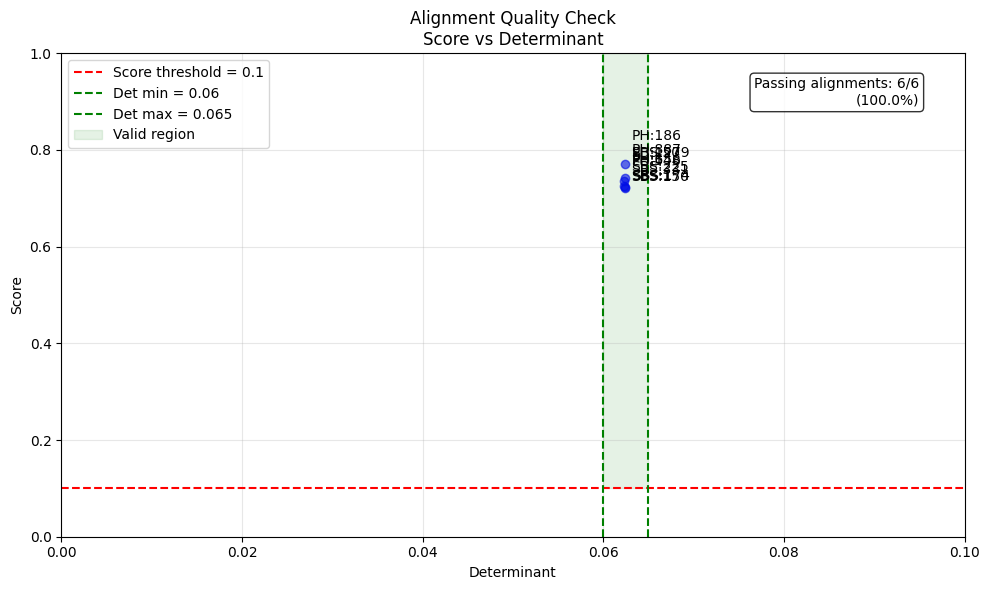

In [5]:
det_range = (0.06, 0.065)
score = 0.1

th.plot_alignment_quality(
    df_initial,
    det_range=det_range,
    score=score,
    xlim=(0, 0.1),
    ylim=(0, 1)
)

##### visualize cell matches based on initial alignment

The following cell contains crucial variables that need to be set according to your specific experimental setup and data organization. Please review and modify these variables as needed before proceeding with the analysis.

- `threshold` This parameter determines the maximum euclidean distance between a phenotype point and its matched SBS point for them to be considered a valid match

Ensure these parameters match your experimental setup before proceeding.

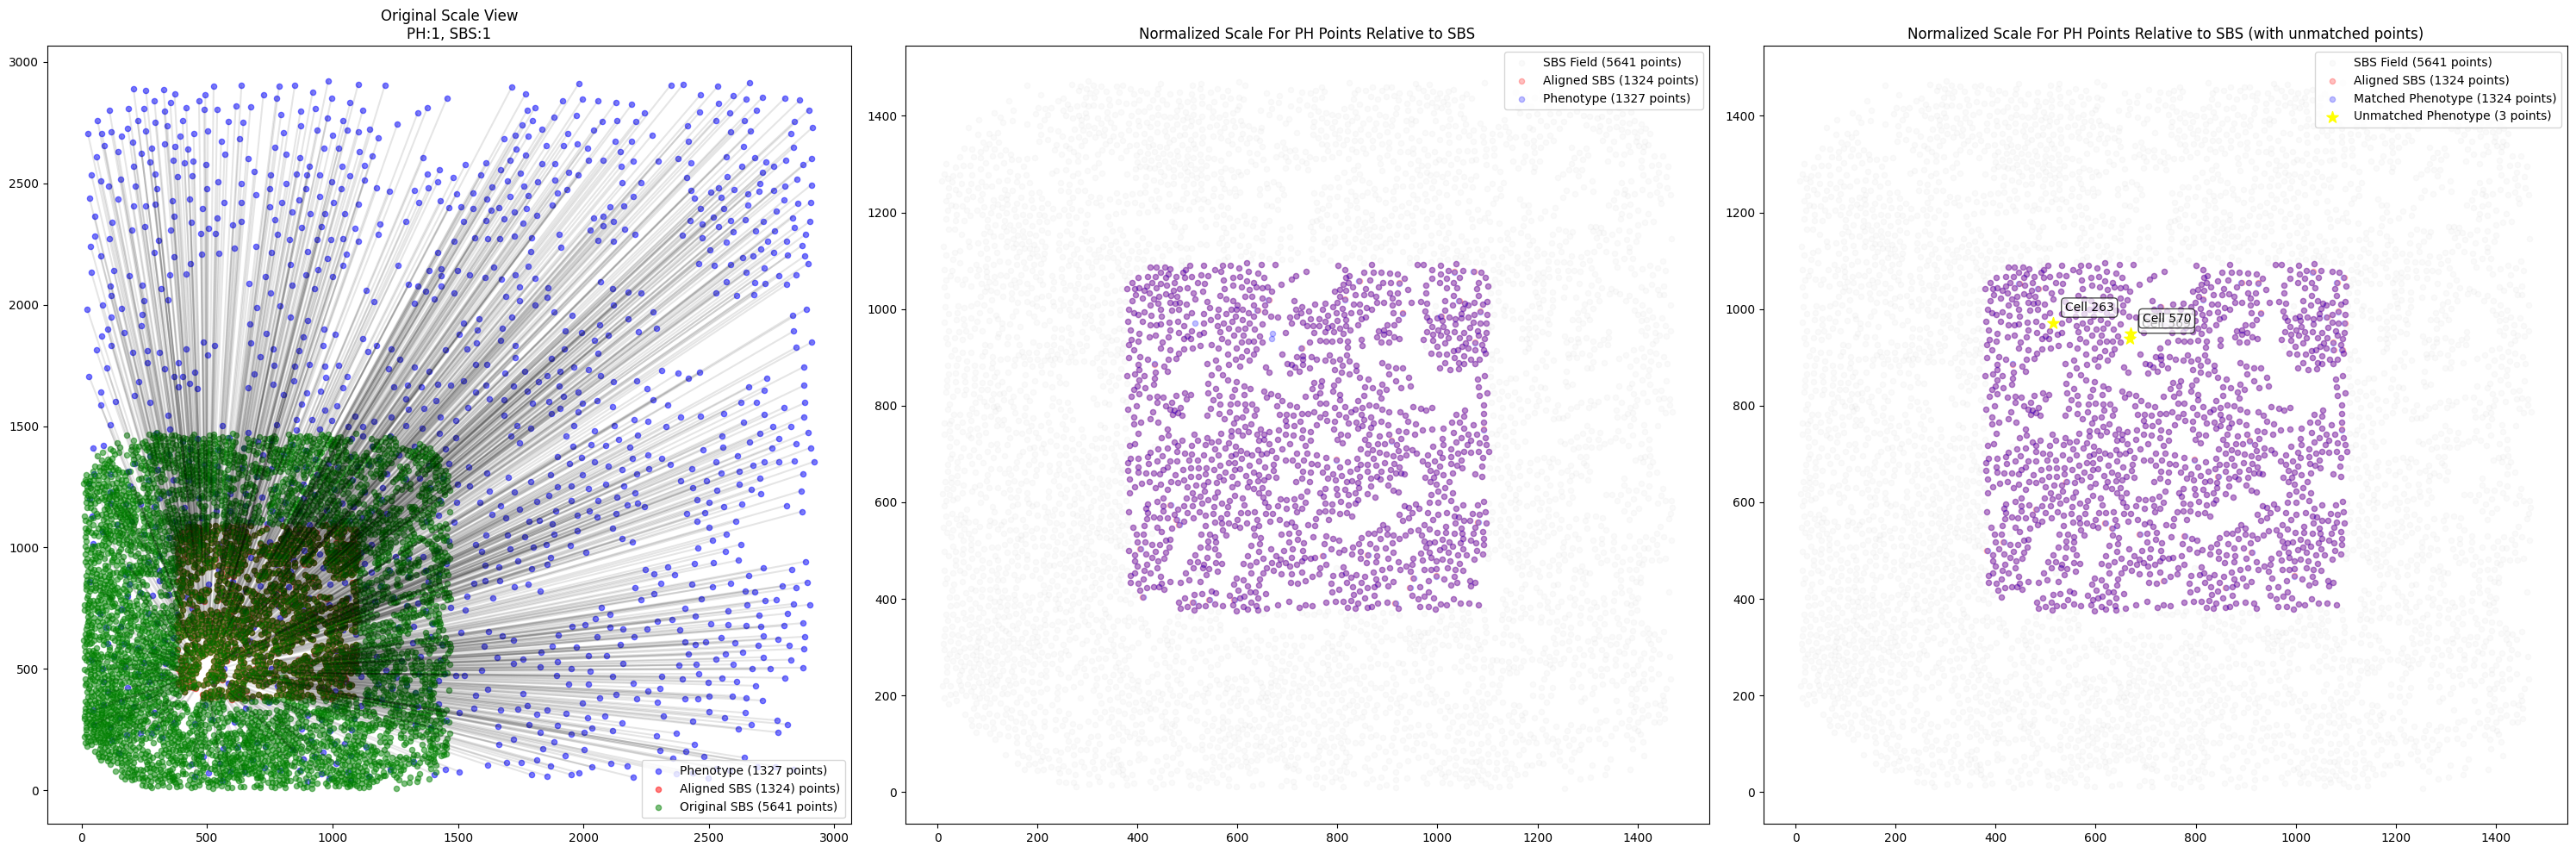

In [6]:
threshold = 2

tile_mask = df_initial['tile'] == initial_sites[0][0]   
site_mask = df_initial['site'] == initial_sites[0][1]
alignment_vec = df_initial[tile_mask & site_mask].iloc[0]

th.plot_merge_example(
    df_ph_info, 
    df_sbs_info,
    alignment_vec,
    threshold=threshold,
)